# AQI During the California, Thomas Fire (2017-18)

The Thomas Fire began late December in Ventura County and continued to affect both Santa Barbara and Ventura counties into the new year (2018). This analysis uses raster data to produce a map of the fire's perimeter. Additionally, a simple visualization was created to demonstrated the severity of the Thomas Fire's affect on air quality (AQI).

## About the Data

### Raster Data
This dataset, from the Landsat Collection 2 Level-2, contains red, green, near-infrared, and shortwave infrared layers. The data was originally collected by the Landsat 8 satellite, and was corrected for surface reflectance and simplified. The final simplified collection can be pulled from the USGS website, which also has more information on image capture and processing.

### Fire Perimeter Data
CAL Fire provides annual geographic data on fire perimeters. The fire started December 4th, 2017 and was contained by January 12th, 2018. Since the majority of fire growth was in 2017, this analysis will use only the 2017 data.

### Air Quality Data
The Air Quality Data can be pulled from the U.S. Environmental Protection Agency (EPA). This dataset provides air quality data from counties throughout the United States and can be filtered to examine Santa Barbara County during the duration of the Thomas Fire.

## Libraries and Functions
Loading necessary libraries and functions:

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches 

import xarray as xr
import rioxarray as rioxr
import geopandas as gpd

## Loading Data
The Landsat raster data and fire perimeter data are stored in a folder and accessed directly. The AQI data can be accessed using the link.

Loading data for analysis:

In [2]:
# raster data
landsat_raw = rioxr.open_rasterio(os.path.join(os.getcwd(),'data','landsat8-2018-01-26-sb-simplified.nc'))

# ca fire perimeter data
fire_perimeter = gpd.read_file(os.path.join(os.getcwd(), 'data', 'fire_perim',
                                           'California_Fire_Perimeters_2017.shp'))
#import 2017 and 2018 aqi data 
aqi_18 = pd.read_csv('https://aqs.epa.gov/aqsweb/airdata/daily_aqi_by_county_2018.zip')
aqi_17 = pd.read_csv('https://aqs.epa.gov/aqsweb/airdata/daily_aqi_by_county_2017.zip')

## Data Cleaning for Visualization
### Raster Data
The raster data contains additional bands that are not needed for this analysis, which will primarily focus on the short-wave infrared (swir22), near infrared (nir08), and red bands. Removing the bands and coordinates which are not needed will improve processing in the following steps. 

In [3]:
# remove extra dims and coords
landsat = landsat_raw.squeeze().drop('band')

### Fire Perimeter Data
As mentioned in the, "About Data" section, the fire perimeter data is for the entire state of California. The data was filtered to the fire of interest, and the coordinate reference system (CRS) was updated for mapping purposes.

In [4]:
# lowercase col names
fire_perimeter.columns = fire_perimeter.columns.str.lower()

# update CRS to match landsat data
fire_perimeter = fire_perimeter.to_crs(landsat.rio.crs)

# filter to fire of interest
thomas = fire_perimeter[fire_perimeter['fire_name']=='THOMAS']

## Mapping the Fire Perimeter
The cleaned and filtered data can be used to produce an aerial map showing the extent of the Thomas Fire's perimeter:

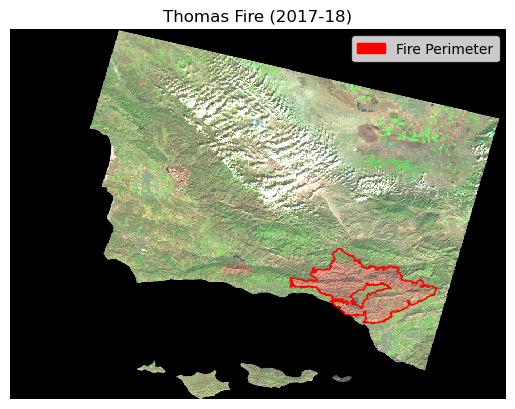

In [34]:
fig, ax = plt.subplots()
ax.axis('off')

# map thomas fire perimeter
thomas.plot(ax=ax, color = 'None', edgecolor = 'red', legend=True)
thomas_patch = mpatches.Patch(color = 'red', label = 'Fire Perimeter') #legend parameters

# map raster data
landsat[['swir22','nir08','red']].to_array().plot.imshow(robust=True) #plot SB county 

# update legend and title
ax.set_title('Thomas Fire (2017-18)')
_ = ax.legend(handles=[thomas_patch]) 

## Analyzing Impact on AQI
As seen in the map above, the Thomas Fire affected large portions of both Santa Barbara and Ventura Counties. The following plot provides...

### Data Cleaning for AQI

In [9]:
# combine 2017-18 AQI data
aqi = pd.concat([aqi_17, aqi_18])

# clean col names
aqi.columns = aqi.columns.str.lower().str.replace(' ','_')

# SB and VC county subset
aqi_sb = aqi.loc[aqi['county_name']=='Santa Barbara',
       ['date','aqi','category','defining_parameter', 'defining_site','number_of_sites_reporting']]

aqi_vc = aqi.loc[aqi['county_name']=='Ventura',
       ['date','aqi','category','defining_parameter', 'defining_site','number_of_sites_reporting']]

# change date col to data time object
aqi_sb.date = pd.to_datetime(aqi_sb.date)
aqi_vc.date = pd.to_datetime(aqi_vc.date)

# set date column as index
aqi_sb = aqi_sb.set_index('date')
aqi_vc = aqi_vc.set_index('date')

# add column w/5-day rolling average
aqi_sb['five_day_average'] = aqi_sb.aqi.rolling('5D').mean()
aqi_vc['five_day_average'] = aqi_vc.aqi.rolling('5D').mean()

## AQI From 2017-208
The following plots show...

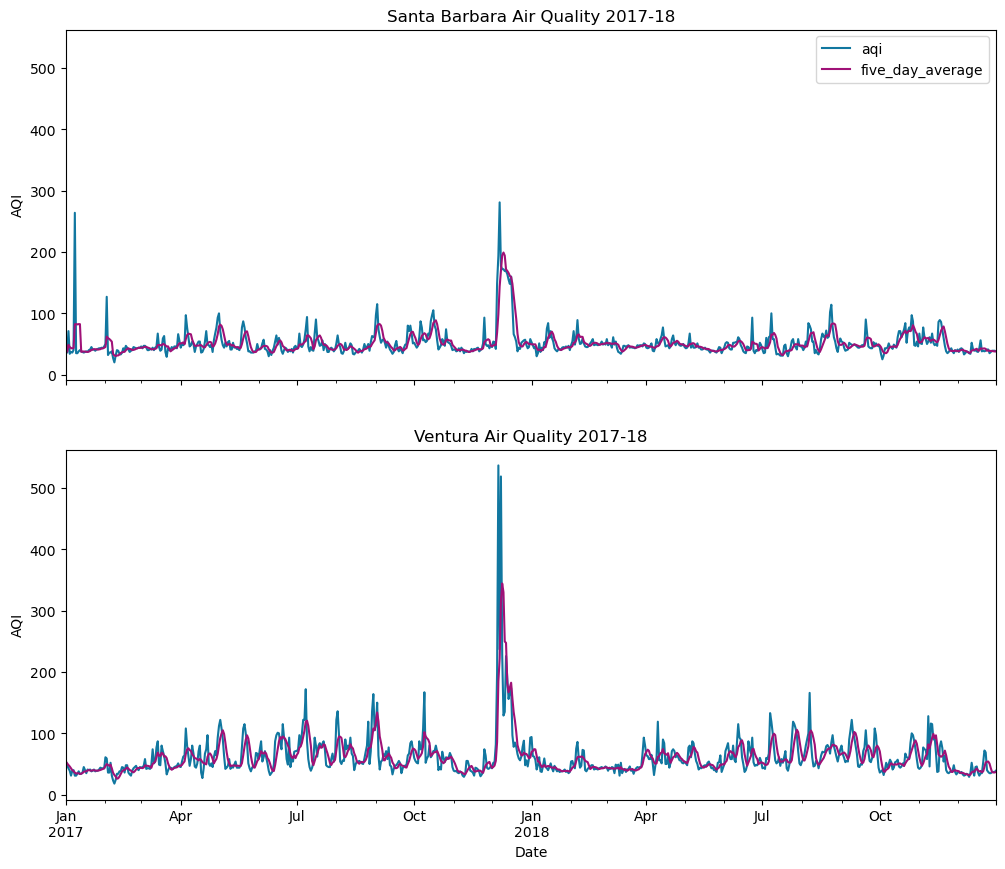

In [33]:
fig, [ax1, ax2] = plt.subplots(ncols=1, nrows=2,
                               sharex = True, sharey=True,
                              figsize = (12,10))

aqi_sb.aqi.plot(ax = ax1, color = '#1177A0', legend = True)  
aqi_sb.five_day_average.plot(ax=ax1, color = '#A01177', 
                            title = 'Santa Barbara Air Quality 2017-18', 
                            legend = True, 
                             xlabel = "Date", 
                             ylabel = "AQI") 

aqi_vc.aqi.plot(ax = ax2, color = '#1177A0', legend = False)  
_ = aqi_vc.five_day_average.plot(ax=ax2, color = '#A01177', 
                            title = 'Ventura Air Quality 2017-18',
                            legend = False, 
                             xlabel = "Date",
                             ylabel = "AQI")